In [1]:
import warnings
warnings.filterwarnings('ignore')
import gzip
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import shapely
import os
geopy.geocoders.options.default_user_agent = "test_user"

In [2]:
#reimport from xls for Clustering
import pandas as pd
LondonCheckinsClf = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClf.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


# <font color='red'>Unsupervised Learning -> K-means and Diff Priv K-means </font>

## Average out the Lat & Long by Suburb to get idea of potential clusters

Using this k-anonymity article as an approach:
https://medium.com/brillio-data-science/a-brief-overview-of-k-anonymity-using-clustering-in-python-84203012bdea

In [3]:
LondonCheckinsCounts = pd.DataFrame(LondonCheckinsClf.groupby('city_district')['city_district'].count().reset_index(name = "Count"))
LondonCheckinsCounts

,city_district,Count
0,London Borough of Bexley,39
1,London Borough of Bromley,556
2,London Borough of Croydon,550
3,London Borough of Lambeth,66
4,London Borough of Lewisham,241
5,London Borough of Southwark,52
6,Plaistow,3
7,Royal Borough of Greenwich,6


In [4]:
LondonCheckins_avg1 = LondonCheckinsClf.groupby(['city_district']).agg({'latitude':['mean','median']})
LondonCheckins_avg2 = LondonCheckinsClf.groupby(['city_district']).agg({'longitude':['mean','median']})
LondonCheckingsSummary = pd.merge(LondonCheckins_avg1, LondonCheckins_avg2, on='city_district', how='outer')
LondonCheckingsSummary =pd.merge(LondonCheckingsSummary, LondonCheckinsCounts, on='city_district', how='outer')
LondonCheckingsSummary

,city_district,"(latitude, mean)","(latitude, median)","(longitude, mean)","(longitude, median)",Count
0,London Borough of Bexley,51.429288,51.426544,0.099133,0.101237,39
1,London Borough of Bromley,51.396957,51.404219,0.029575,0.019371,556
2,London Borough of Croydon,51.378851,51.375049,-0.098305,-0.097711,550
3,London Borough of Lambeth,51.434481,51.433219,-0.100883,-0.103632,66
4,London Borough of Lewisham,51.435475,51.438734,-0.026629,-0.042801,241
5,London Borough of Southwark,51.435669,51.433655,-0.078644,-0.080230,52
6,Plaistow,51.402489,51.402553,0.016855,0.017269,3
7,Royal Borough of Greenwich,51.438849,51.438118,0.064064,0.071004,6


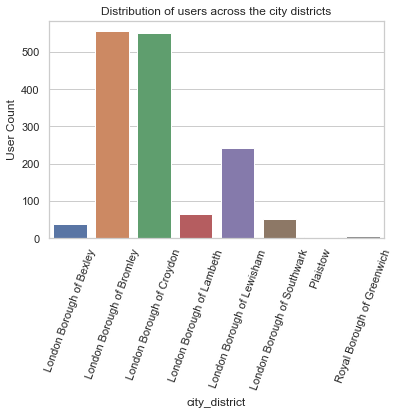

In [5]:
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(data=LondonCheckingsSummary, x='city_district', y='Count')

# Labels
plt.xticks(rotation=70)
plt.title('Distribution of users across the city districts')
plt.xlabel('city_district')
plt.ylabel('User Count')

plt.show()

In [6]:
# get london stations from https://www.doogal.co.uk/london_stations.php and put in CSV
LondonStations = pd.read_csv("C:\\Users\\Basia\Downloads\\LondonTrainStations.csv") 
FilterLatsStations = LondonStations[(LondonStations['Latitude']>= 51.345375) & (LondonStations['Latitude']<= 51.444771)]
LondonStations = FilterLatsStations[(FilterLatsStations['Longitude']>= -0.123386) & (FilterLatsStations['Longitude']<=0.112477)]
LondonStations.head(1000)

,Station,Postcode,Latitude,Longitude
5,Addington Village,CR0 5AR,51.356239,-0.032665
6,Addiscombe,CR0 7AA,51.379808,-0.073213
15,Anerley,SE20 8PY,51.412517,-0.065137
19,Arena,SE25 4RY,51.391523,-0.058319
22,Avenue Road,BR3 4NJ,51.406798,-0.049447
...,...,...,...,...
609,West Croydon,CR0 2TA,51.378552,-0.102034
611,West Dulwich,SE21 8HN,51.440912,-0.090673
620,West Norwood,SE27 0HS,51.431241,-0.103189
624,West Wickham,BR4 0PY,51.381284,-0.014576


## Remove columns not needed for unsupervised learning

In [7]:
#reimport from xls for Clustering
import pandas as pd
LondonCheckinsClf = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClf.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


LondonCheckinsClf.dtypes

** removing columns for Clustering including user because not trying to predict here **

In [8]:

LondonCheckinsClf = LondonCheckinsClf.drop(['location_id','check_in_time','checkin_Date','user',
                                            'checkin_time','checkin_year','checkin_day','Address'
                                            ,'checkin_hour','checkin_weekday','checkin_month','city_district','Location'
                                            #'latitude','longitude'
                                           ], axis=1)
LondonCheckinsClf

,latitude,longitude
0,51.442041,-0.004450
1,51.375217,-0.103929
2,51.375217,-0.103929
3,51.374846,-0.103378
4,51.379984,-0.101773
...,...,...
1508,51.411516,-0.121704
1509,51.381669,-0.114972
1510,51.404219,0.015095
1511,51.400061,0.017416


# First use KMeans clustering on Non Privatised Data

In [9]:
#libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_samples
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using this k-anonymity article as an approach:
https://medium.com/brillio-data-science/a-brief-overview-of-k-anonymity-using-clustering-in-python-84203012bdea

1. first see if i can group the data lat and long on average. By London Burrough it shows that there shouldn't be less than 39 users per cluster in this dataset

Text(0, 0.5, 'Inertia')

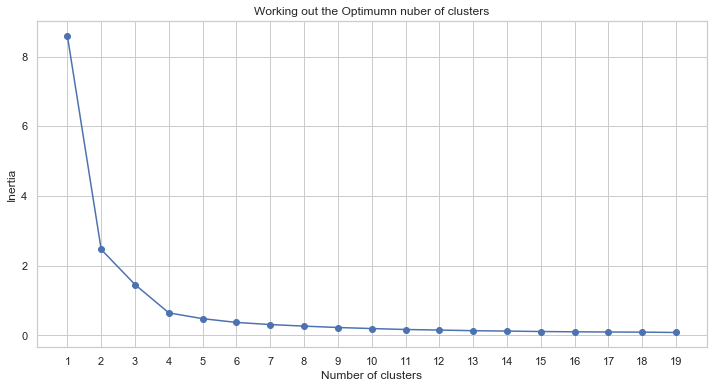

In [10]:
# Working out the best valuse of K (how many clusters)
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++',max_iter = 300, n_init = 10, random_state=2021)
    kmeans.fit(LondonCheckinsClf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xticks(np.arange(min(frame['Cluster']), max(frame['Cluster'])+1, 1.0))
plt.title("Working out the Optimumn nuber of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [11]:
# k=5 is where the elbow is in inertia where increasing the number of clusters won't change much

In [12]:
kmeans = KMeans(n_clusters=5, init='k-means++',max_iter = 300, n_init = 10, random_state=2021)
nonprivate_kmeans = kmeans.fit_predict(LondonCheckinsClf)
c = Counter(kmeans.labels_)
print(c.items())

dict_items([(3, 347), (2, 494), (1, 221), (4, 204), (0, 247)])


homogeneity: each cluster contains only members of a single class.
completeness: all members of a given class are assigned to the same cluster.

In [13]:
from sklearn.metrics.cluster import completeness_score
from sklearn import metrics

metrics.homogeneity_score(nonprivate_kmeans,  kmeans.labels_)

1.0

In [14]:
metrics.completeness_score(nonprivate_kmeans,  kmeans.labels_)

1.0

Perfect labeling!!

In [15]:
#silhouette
scores = silhouette_samples(LondonCheckinsClf, kmeans.labels_)

LondonCheckinsClf["kMeansLabels"] = kmeans.labels_
LondonCheckinsClf["silhouetteScores"] = scores

LondonCheckinsClf = LondonCheckinsClf.sort_values("silhouetteScores")
c.items()

dict_items([(3, 347), (2, 494), (1, 221), (4, 204), (0, 247)])

Text(0.5, 0, 'longitude')

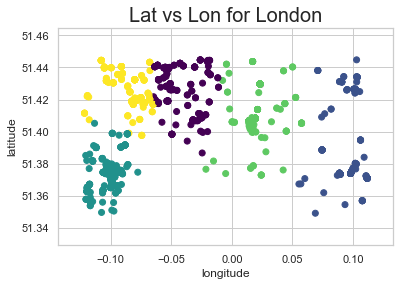

In [16]:
plt.scatter(LondonCheckinsClf["longitude"], LondonCheckinsClf["latitude"],
            c=LondonCheckinsClf["kMeansLabels"] ,cmap = "viridis")

plt.title("Lat vs Lon for London",fontsize = 20)
plt.ylabel("latitude")
plt.xlabel("longitude")

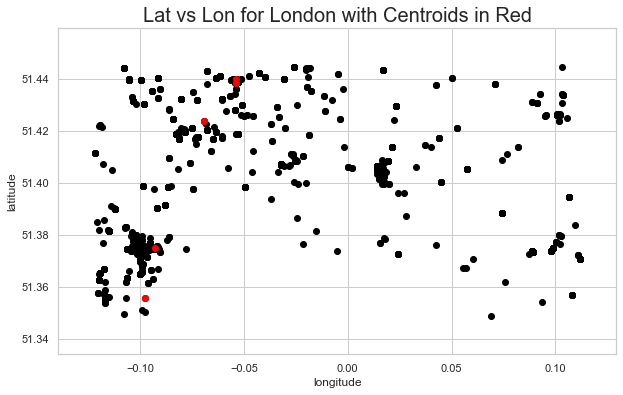

In [17]:
X = LondonCheckinsClf[["longitude","latitude"]]
K=5
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.figure(figsize=(10,6))
plt.title("Lat vs Lon for London with Centroids in Red",fontsize = 20)
plt.scatter(X["longitude"],X["latitude"],c='black')
plt.scatter(Centroids["longitude"],Centroids["latitude"],c='red')
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.show()

In [18]:
# Assign all the points to the closest cluster centroid & Recompute centroids of newly formed clusters
diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["latitude"]-row_d["latitude"])**2
            d2=(row_c["longitude"]-row_d["longitude"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["kMeansLabels"]=C
    Centroids_new = X.groupby(["kMeansLabels"]).mean()[["longitude","latitude"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['longitude'] - Centroids['longitude']).sum() + (Centroids_new['latitude'] - Centroids['latitude']).sum()
        print(diff.sum())
    Centroids = X.groupby(["kMeansLabels"]).mean()[["longitude","latitude"]]
    #https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

0.00890322967073377
-0.000962205319371752
-0.002674416921693859
0.0


In [19]:
"""color=['orangered','slateblue','mediumspringgreen','fuchsia','grey','orange','pink','blue']
for k in range(K):
    data=X[X["kMeansLabels"]==k+1]
    plt.scatter(data["longitude"],data["latitude"],c=color[k])
    plt.scatter(Centroids["longitude"],Centroids["latitude"],c='red')

plt.title("Lat vs Lon for London with clusters & Centroids",fontsize = 20)
plt.ylabel("latitude")
plt.xlabel("longitude")"""

'color=[\'orangered\',\'slateblue\',\'mediumspringgreen\',\'fuchsia\',\'grey\',\'orange\',\'pink\',\'blue\']\nfor k in range(K):\n    data=X[X["kMeansLabels"]==k+1]\n    plt.scatter(data["longitude"],data["latitude"],c=color[k])\n    plt.scatter(Centroids["longitude"],Centroids["latitude"],c=\'red\')\n\nplt.title("Lat vs Lon for London with clusters & Centroids",fontsize = 20)\nplt.ylabel("latitude")\nplt.xlabel("longitude")'

In [20]:
LondonCheckinsClf.head()

,latitude,longitude,kMeansLabels,silhouetteScores
451,51.421747,-0.064603,0,-0.061053
1102,51.399064,-0.085001,4,-0.049344
1072,51.407406,-0.117828,4,-0.028070
193,51.443237,-0.067867,4,-0.014377
215,51.443237,-0.067867,4,-0.014377


In [21]:
LondonCheckinsClf.shape

(1513, 4)

In [22]:
LondonCheckinsClf.kMeansLabels.unique()

array([0, 4, 1, 3, 2])

## Apply logistic regression on the clusters

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, zero_one_loss

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    LondonCheckinsClf.drop('kMeansLabels', axis=1), LondonCheckinsClf['kMeansLabels'],
      test_size=0.33, random_state=2021)

In [25]:
NonPrivateClss = LogisticRegression(solver="lbfgs")
NonPrivateClss.fit(X_train, y_train)
NonPriv_pred_clss = NonPrivateClss.predict(X_test)
NonPriv_pred_train_clss = NonPrivateClss.predict(X_train)
clss_error = zero_one_loss(y_test, NonPriv_pred_clss)

print("Training set score: %.2f%%" % (NonPrivateClss.score(X_train, y_train) * 100))
print("Test set score: %.2f%%" % (NonPrivateClss.score(X_test, y_test) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 70.09%
Test set score: 69.60%
Error: 30.40%


In [53]:
ClusterColours = {0: 'purple', 1 : 'orange', 2 :'green',3 :'orange',4 :'grey',5 :'cyan',6 :'pink',7 :'yellow'}
LondonCheckinsClf['ClusterColour'] = LondonCheckinsClf.kMeansLabels.map(ClusterColours)
LondonCheckinsClf['ClusterSize'] = 0.1
LondonCheckinsClf

,latitude,longitude,kMeansLabels,silhouetteScores,ClusterColour,ClusterSize
451,51.421747,-0.064603,0,-0.061053,purple,0.1
1102,51.399064,-0.085001,4,-0.049344,grey,0.1
1072,51.407406,-0.117828,4,-0.028070,grey,0.1
193,51.443237,-0.067867,4,-0.014377,grey,0.1
215,51.443237,-0.067867,4,-0.014377,grey,0.1
...,...,...,...,...,...,...
263,51.373896,-0.098976,2,0.827824,green,0.1
525,51.373896,-0.098976,2,0.827824,green,0.1
1319,51.374292,-0.097018,2,0.827860,green,0.1
1479,51.373878,-0.098541,2,0.828288,green,0.1


In [54]:
#plot the user points and add train stations as recommender locations
fig = px.scatter_mapbox(LondonCheckinsClf, lat="latitude", lon="longitude", hover_name="kMeansLabels", 
                        color="kMeansLabels",size ="ClusterSize", zoom=10,  width=1000, height=600)


#add the train stations
fig.add_trace(px.scatter_mapbox(LondonStations, lat="Latitude", lon="Longitude", hover_name="Station",
                                color_discrete_sequence=["black"],size_max=30, zoom=10, width=1000, height=600).data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

# Now apply Diferential Privacy K-Means Clustering

In [28]:
#libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_samples
%matplotlib inline
import os
from sklearn.metrics import confusion_matrix

##the IBM diff privacy KMeans model
from diffprivlib.models import KMeans as DPKMeans

## Cit https://diffprivlib.readthedocs.io/en/latest/modules/models.html#clustering-models

In [29]:
# removing columns that don't add to ML & privacy for DIFF PRIV K MEANS
LondonCheckinsClfPRIV = LondonCheckinsClf.drop(['silhouetteScores','ClusterColour','ClusterSize','kMeansLabels'], axis=1)
LondonCheckinsClfPRIV.head()

,latitude,longitude
451,51.421747,-0.064603
1102,51.399064,-0.085001
1072,51.407406,-0.117828
193,51.443237,-0.067867
215,51.443237,-0.067867



Cit https://diffprivlib.readthedocs.io/en/latest/modules/models.html#clustering-models

epsilon (float, default: 0.2) – Privacy parameter ϵ.

bounds (tuple, optional) – Bounds of the data, provided as a tuple of the form (min, max). min and max can either be scalars, covering the min/max of the entire data, or vectors with one entry per feature. If not provided, the bounds are computed on the data when .fit() is first called, resulting in a PrivacyLeakWarning.

n_clusters (int, 3) – The number of clusters to form as well as the number of centroids to generate.

accountant (BudgetAccountant, optional) – Accountant to keep track of privacy budget.(

Text(0, 0.5, 'Inertia')

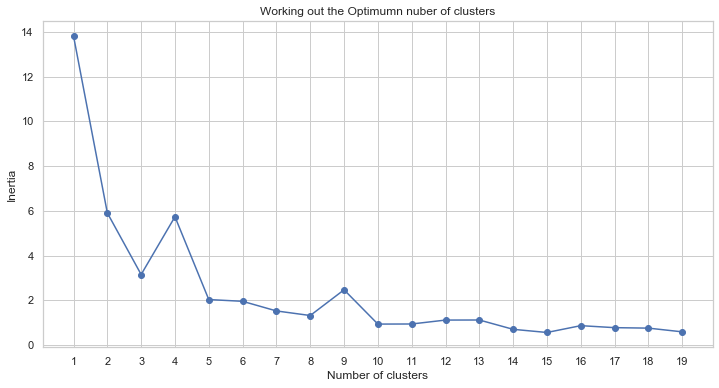

In [30]:
# Working out the best value of K (how many clusters)
import warnings
warnings.filterwarnings("ignore")

SSE = []
for cluster in range(1,20):
    kmeansPRIV = DPKMeans(n_jobs = -1, n_clusters = cluster, epsilon=0.1, bounds=None, accountant=None, random_state=2021)
    kmeansPRIV.fit(LondonCheckinsClfPRIV)
    SSE.append(kmeansPRIV.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xticks(np.arange(min(frame['Cluster']), max(frame['Cluster'])+1, 1.0))
plt.title("Working out the Optimumn nuber of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [31]:
LondonCheckinsClfPRIV.head()

,latitude,longitude
451,51.421747,-0.064603
1102,51.399064,-0.085001
1072,51.407406,-0.117828
193,51.443237,-0.067867
215,51.443237,-0.067867


In [32]:
K=5
kmeansP = DPKMeans(n_clusters = K, epsilon=0.1, bounds=None, accountant=None, random_state=2021)
DPKmeans = kmeansP.fit(LondonCheckinsClfPRIV)
cdp = Counter(kmeansP.labels_)
print(cdp.items())

#nonprivate dict_items([(3, 151), (2, 654), (1, 202), (4, 86), (0, 404)])
#or
# epsilon=float("inf") dict_items([(0, 404), (2, 151), (3, 202), (1, 86), (4, 654)]) -same as non-private

# epsilon=1 dict_items([(2, 569), (1, 276), (4, 192), (0, 22), (3, 438)])
# epsilon=.8 dict_items([(2, 675), (3, 202), (0, 252), (1, 335), (4, 33)])
# epsilon=.5 dict_items([(2, 720), (3, 490), (0, 6), (4, 201), (1, 80)])
# epsilon=.3 dict_items([(3, 709), (0, 181), (4, 273), (1, 328), (2, 6)])
# epsilon=.2 dict_items([(4, 1158), (2, 37), (3, 218), (0, 49), (1, 35)])
# epsilon=.1 dict_items([(3, 106), (0, 790), (2, 175), (4, 349), (1, 77)])

dict_items([(1, 767), (3, 228), (0, 486), (4, 18), (2, 14)])


In [33]:
#silhouette
DPscores = silhouette_samples(LondonCheckinsClfPRIV, kmeansP.labels_)

LondonCheckinsClfPRIV["DPkMeansLabels"] = kmeansP.labels_
LondonCheckinsClfPRIV["DPsilhouetteScores"] = DPscores

LondonCheckinsClfPRIV = LondonCheckinsClfPRIV.sort_values("DPsilhouetteScores")
cdp.items()

dict_items([(1, 767), (3, 228), (0, 486), (4, 18), (2, 14)])

In [34]:
LondonCheckinsClfPRIV.DPkMeansLabels.unique()

array([3, 4, 0, 1, 2], dtype=int64)

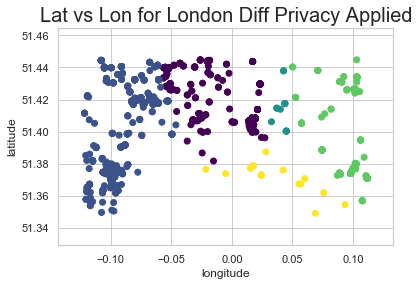

In [35]:
plt.scatter(LondonCheckinsClfPRIV["longitude"],LondonCheckinsClfPRIV["latitude"], 
            c=LondonCheckinsClfPRIV["DPkMeansLabels"] ,cmap = "viridis")

plt.title("Lat vs Lon for London Diff Privacy Applied",fontsize = 20)
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.show()

In [36]:
LondonCheckinsClfPRIV.head()

,latitude,longitude,DPkMeansLabels,DPsilhouetteScores
745,51.421320,0.052706,3,-0.694348
744,51.421320,0.052706,3,-0.694348
746,51.421320,0.052706,3,-0.694348
1282,51.440313,0.050184,3,-0.595281
726,51.440313,0.050184,3,-0.595281


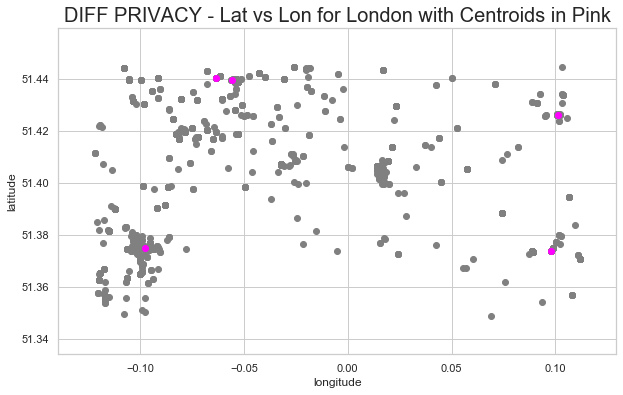

In [37]:
Z = LondonCheckinsClfPRIV[["longitude","latitude"]]
K=5
# Select random observation as centroids
DPCentroids = (Z.sample(n=K))
plt.figure(figsize=(10,6))
plt.title("DIFF PRIVACY - Lat vs Lon for London with Centroids in Pink",fontsize = 20)
plt.scatter(Z["longitude"],Z["latitude"],c='grey')
plt.scatter(DPCentroids["longitude"],DPCentroids["latitude"],c='fuchsia')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

In [38]:
# Assign all the points to the closest cluster centroid & Recompute centroids of newly formed clusters
diff = 1
j=0

while(diff!=0):
    XD=Z
    i=1
    for index1,row_c in DPCentroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["latitude"]-row_d["latitude"])**2
            d2=(row_c["longitude"]-row_d["longitude"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        Z[i]=ED
        i=i+1

    C=[]
    for index,row in Z.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    Z["DPkMeansLabels"]=C
    DPCentroids_new = Z.groupby(["DPkMeansLabels"]).mean()[["longitude","latitude"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (DPCentroids_new['longitude'] - DPCentroids['longitude']).sum() + (DPCentroids_new['latitude'] - DPCentroids['latitude']).sum()
        print(diff.sum())
    DPCentroids = Z.groupby(["DPkMeansLabels"]).mean()[["longitude","latitude"]]
    #https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

0.0206454951871484
0.03195552541683945
0.009360290256527473
0.005549261339181877
0.0032216372713828254
0.000166841640066525
0.00016160779166595265
0.0


In [39]:
"""color=['orangered','slateblue','mediumspringgreen','grey','orange','blue','green','cyan','pink','yellow']
for k in range(K):
    dataDP=Z[Z["DPkMeansLabels"]==k+1]
    plt.scatter(dataDP["longitude"],dataDP["latitude"],c=color[k])
    plt.scatter(DPCentroids["longitude"],DPCentroids["latitude"],c='black')

plt.title("DIFF PRIVACY - Lat vs Lon for London with clusters & Centroids",fontsize = 20)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()"""

'color=[\'orangered\',\'slateblue\',\'mediumspringgreen\',\'grey\',\'orange\',\'blue\',\'green\',\'cyan\',\'pink\',\'yellow\']\nfor k in range(K):\n    dataDP=Z[Z["DPkMeansLabels"]==k+1]\n    plt.scatter(dataDP["longitude"],dataDP["latitude"],c=color[k])\n    plt.scatter(DPCentroids["longitude"],DPCentroids["latitude"],c=\'black\')\n\nplt.title("DIFF PRIVACY - Lat vs Lon for London with clusters & Centroids",fontsize = 20)\nplt.ylabel(\'latitude\')\nplt.xlabel(\'longitude\')\nplt.show()'

In [40]:
LondonCheckinsClfPRIV.head()

,latitude,longitude,DPkMeansLabels,DPsilhouetteScores
745,51.421320,0.052706,3,-0.694348
744,51.421320,0.052706,3,-0.694348
746,51.421320,0.052706,3,-0.694348
1282,51.440313,0.050184,3,-0.595281
726,51.440313,0.050184,3,-0.595281


In [41]:
LondonCheckinsClfPRIV.DPkMeansLabels.unique()

array([3, 4, 0, 1, 2], dtype=int64)

# Applying Logistic regression over results.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, zero_one_loss

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainP, X_testP, y_trainP, y_testP = train_test_split(
    LondonCheckinsClfPRIV.drop('DPkMeansLabels', axis=1), LondonCheckinsClfPRIV['DPkMeansLabels'],
      test_size=0.33, random_state=2021)

In [44]:
DPClss = LogisticRegression()
DPClss.fit(X_trainP, y_trainP)
DP_pred_clss = DPClss.predict(X_testP)
DP_pred_train_clss = DPClss.predict(X_trainP)
clss_error = zero_one_loss(y_testP, DP_pred_clss)

print("Training set score: %.2f%%" % (DPClss.score(X_trainP, y_trainP) * 100))
print("Test set score: %.2f%%" % (DPClss.score(X_testP, y_testP) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 84.21%
Test set score: 85.60%
Error: 14.40%


In [45]:
ClusterColours1 = {0: 'purple', 1 : 'orange', 2 :'green',3 :'orange',4 :'grey',5 :'cyan',6 :'pink',7 :'yellow'}
LondonCheckinsClfPRIV['ClusterColour'] = LondonCheckinsClfPRIV.DPkMeansLabels.map(ClusterColours1)
LondonCheckinsClfPRIV['ClusterSize'] = .2
LondonCheckinsClfPRIV

,latitude,longitude,DPkMeansLabels,DPsilhouetteScores,ClusterColour,ClusterSize
745,51.421320,0.052706,3,-0.694348,orange,0.2
744,51.421320,0.052706,3,-0.694348,orange,0.2
746,51.421320,0.052706,3,-0.694348,orange,0.2
1282,51.440313,0.050184,3,-0.595281,orange,0.2
726,51.440313,0.050184,3,-0.595281,orange,0.2
...,...,...,...,...,...,...
1292,51.413947,0.040081,2,0.762828,green,0.2
997,51.417489,0.043787,2,0.776901,green,0.2
987,51.417489,0.043787,2,0.776901,green,0.2
887,51.417489,0.043787,2,0.776901,green,0.2


In [46]:
LondonCheckinsClfPRIV.ClusterColour.unique()

array(['orange', 'grey', 'purple', 'green'], dtype=object)

In [55]:
#plot the user points and add train stations as recommender locations
fig = px.scatter_mapbox(LondonCheckinsClfPRIV, lat="latitude", lon="longitude", hover_name="DPkMeansLabels", 
                       color="DPkMeansLabels",size ='ClusterSize', zoom=10, width=1000, height=600)

#add the train stations
fig.add_trace(px.scatter_mapbox(LondonStations, lat="Latitude", lon="Longitude", hover_name="Station", 
                        color_discrete_sequence=["black"],size_max=30, zoom=10, width=1000, height=600).data[0])
 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()